# Krylov-fueled Iterative Quantum Assisted Eigensolver

## Introduction

The main bottleneck in determining ground state energies of an Hamiltonian is the exponential growth of the Hilbert space size. One way to tackle this issue is to use variational quantum algorithms such as VQE.
Nonetheless VQE methods are sensitive to Barren plateaus. In addition the classical optimisation task is often facing high dimensional non-convex playgrounds, which complexify the task. The typical ansatz used (UCCSD, Givens rotations) are often quite deep and therefore not applicable considering NISQ devices.

All in all, alternative methods can lead to similar or better results. This repository will explore the following paper from Bharti, K., & Haug, T. (n.d.).  *Iterative Quantum Assisted Eigensolver* . [https://arxiv.org/pdf/2010.05638.pdf] 

The idea is to search for the ground state in a subspace instead of the whole Hilbert space. The difficulty now lies in finding a good search subspace. The work done here is close to the pennylane tutorial *Classically boosted VQE* [https://pennylane.ai/qml/demos/tutorial_classically_boosted_vqe.html]. The main drawback in the latter is the use of Hadamard tests to compute off-diagonal elements.
Nonetheless, one can still calculate these elements as expectation values of some state, granted a tailored subspace exploration.

The article mentioned above (IQAE) makes use of Krylov-inspired spaces defined as follow:

Let $\ket{\psi_0}$ be an initial state (we take here the output of the VQE)

Let $H$ be a hamiltonian defined as a pauli sentence

$$ H = \sum_i^r \beta_i U_i$$

We then define $\mathbb{CS_K}$, $K\in \mathbb{N}$:

$$ \mathbb{S_0} = \{\ket{\psi_0}\} ,\qquad \mathbb{S_j} = \{ U_{i_1} \cdots U_{i_j}  \ket{\psi_0} \}_{i_1=1, \cdots i_j=1}^r  \quad \forall j\\
    \quad \\
    \mathbb{CS_K} = \bigcup_{j=1}^r \mathbb{S_j}
$$


The advantage of using this subspace is that every element of the basis is of the form of a Pauli word times the same state $\ket{\psi_0}$, so that every matrix element is an expectation value of a Pauli Sentence. The picture below explains the different steps to follow



<img src="img/pic1.png" alt= “” width="600" height="300">

The first step (1) is to create the Pauli word Basis $\mathbb{CS_K}$. Then we calculate the overlap matrix $\mathcal{E}$ (labeled in the code as S) and $\mathcal{D}$ (2). As explained, the matrix elements of $\mathcal{E}$ and $\mathcal{D}$ are expectation values of some Pauli word $Q_{nm}$, which can then be efficiently computed on a quantum compouter with pennylane.

$$ \mathcal{E}_{nm} =  \braket{\chi_n | \chi_m} \\
                    = \bra{\psi_0} P_n^{\dagger} P_m\ket{\psi_0}\\
                    = \bra{\psi_0} Q_{nm} \ket{\psi_0}
$$

Note that the two matrices are hermitian.

Now that we have calculated the matrices, we can search for the ground state by solving the constrained minimisation problem (3). This can be recast as a generalised eigenvalue problem of the form
$$
\mathcal{D} \alpha = \lambda \mathcal{E} \alpha
$$
This generalised eigenvalue problem is solved classically using scipy.

In [1]:
%load_ext autoreload
%autoreload 2

from pennylane import numpy as np
import pennylane as qml
import pickle
import scipy
from scipy.linalg import eigh

from IQAE_toolbox import *
import matplotlib.pyplot as plt


## Molecular definition

We create here the definition of the molecule parameters. The frozen core approxiamtion is used, with an equilibirum bond length taken from the litterature. The total number of spin-orbitals is therefore 12 with 4 active electrons.

The Hamiltonian is defined with the Jordan-Wigner mapping (12 qubits), and tapered with $\mathbb{Z_2}$ symmetries down to 7 qubits

In [2]:
n_electrons = 4
n_orbitals = 6


symbols = ["H", "Be", "H"]
coordinates = angstrom_to_bohr(np.array([0.0, 0.0, -1.3264, 0.0, 0.0,0.0, 0.0, 0.0, 1.3264], requires_grad=False))

H, n_qubits = qml.qchem.molecular_hamiltonian(symbols,
                                                coordinates,
                                                basis='sto-3G',
                                                active_electrons=n_electrons,
                                                active_orbitals=n_orbitals)
print("Number of qubits = ", n_qubits)
print("Number of terms in H = ", len(H.coeffs))
#print("The Hamiltonian is ", H)

Number of qubits =  12
Number of terms in H =  327


In [3]:
generators = qml.symmetry_generators(H)
paulixops = qml.paulix_ops(generators, n_qubits)
paulix_sector = qml.qchem.optimal_sector(H, generators, n_electrons)

H_tapered = qml.taper(H, generators, paulixops, paulix_sector)

state_tapered = qml.qchem.taper_hf(generators, paulixops, paulix_sector,
                                   num_electrons=n_electrons, num_wires=len(H.wires))

/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1830: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(
/Users/Brian/workspace/Research/QHack2023/.conda/lib/python3.10/site-packages/pennylane/operation.py:1993: UserWarning: Tensor object acts on overlapping wires; in some PennyLane functions this will lead to undefined behaviour
  warnings.warn(


## Standard VQE

The ansatz used is Givens rotations based, tapered in order to fit the tapered Hamiltonian.
Note that no Adapt-VQE technique has been used (all the excitations are taken into account). This could be used to remove vanishing-gradients excitations. However the goal of the VQE here is just to provide an initial state for the IQAE method.

In [4]:
singles, doubles = qml.qchem.excitations(n_electrons, len(H.wires))
print('singles', len(singles), 'doubles ', len(doubles))
tapered_doubles = [
    qml.taper_operation(qml.DoubleExcitation, generators, paulixops, paulix_sector,
                        wire_order=H.wires, op_wires=double) for double in doubles
]
tapered_singles = [
    qml.taper_operation(qml.SingleExcitation, generators, paulixops, paulix_sector,
                        wire_order=H.wires, op_wires=single) for single in singles
]

dev = qml.device("default.qubit", wires=H_tapered.wires)

@qml.qnode(dev)
def tapered_circuit(params):
    qml.BasisState(state_tapered, wires=H_tapered.wires)
    for idx, tapered_op in enumerate(tapered_doubles + tapered_singles):
        tapered_op(params[idx])
    return qml.expval(H_tapered)

singles 16 doubles  76


In [5]:
optimizer = qml.GradientDescentOptimizer(stepsize=0.5)
params = np.zeros(len(doubles) + len(singles), requires_grad=True)

for n in range(1, 41):
    params, energy = optimizer.step_and_cost(tapered_circuit, params)
    if not n % 5:
        print(f"n: {n}, E: {energy:.8f} Ha")

n: 5, E: -15.59269690 Ha
n: 10, E: -15.59431804 Ha
n: 15, E: -15.59444016 Ha
n: 20, E: -15.59446158 Ha
n: 25, E: -15.59446621 Ha
n: 30, E: -15.59446725 Ha
n: 35, E: -15.59446749 Ha
n: 40, E: -15.59446755 Ha


In [6]:
@qml.qnode(dev)
def taperedState_circuit(params):
    qml.BasisState(state_tapered, wires=H_tapered.wires)
    for idx, tapered_op in enumerate(tapered_doubles + tapered_singles):
        tapered_op(params[idx])
    return qml.state()

psi0 = taperedState_circuit(params)
import pickle
with open('gs_vqe.pkl','wb') as f:
    pickle.dump(psi0, f)


For reference, the exact ground state energy of our model (approximated Hamiltonian) is $-15.594837897448235$ Ha

The VQE energy reached is $-15.59446755$ Ha

The goal of the IQAE (following section) is to get closer the exact ground state above, starting from the VQE result.

## IQAE method


<img src="img/pic1.png" alt= “” width="600" height="300">

In [7]:
qubits_tap = n_qubits-len(paulixops)
wire_tapered = [ paulixops[i].wires[0] for i in range(len(paulixops))]
wire_tap = [ x for x in range(n_qubits) if not x in wire_tapered ]
wire_map = {wire:i for i,wire in enumerate(wire_tap)}

#H_tapered = qml.map_wires(H_tapered_oldwires,wire_map)

In [8]:
dev = qml.device("default.qubit", wires=qubits_tap)

The following cell is computing the expectation value of a product between two Pauli words with a Hamiltonian sandwiched in between.
A much cleaner code is provided in IQAE_toolbox.py named "expectation_obs". However discrepencies in the results of the matrix D prevented us to use these clean codes (see explanation and reproducer in IQAE_toolbox.py under the tag  "LESS CLEAN FUNCTIONS (that work)")}

In [9]:
def expectation_value_H(P1,P2, H=qml.Hamiltonian(coeffs=[1], observables=[qml.Identity(wires=range(qubits_tap))] )):
    N = len(H.coeffs)
    Phase = np.zeros((N), dtype=int, requires_grad=False)
    Pauli = np.empty((N), dtype='U'+str(qubits_tap), requires_grad=False)
    for i in range(N):
        P_H = qml.pauli.pauli_word_to_string(H.ops[i],wire_map)
        phase, P = Ps_multiply(P1,P_H,P2)
        Phase[i] = phase
        Pauli[i] = P
    
    @qml.qnode(dev)
    def expect():
        H_ = qml.Hamiltonian([ H.coeffs[i]*np.exp(1j*np.pi/2*Phase[i])       for i in range(N)],
                             [ qml.pauli.string_to_pauli_word(str(Pauli[i])) for i in range(N)],\
                              simplify=False)
        qml.QubitStateVector(psi0, range(qubits_tap))
        return qml.expval(H_)
    return expect()

Now we can compute the overlap matrix S and the matrix D (overlap with the Hamiltonian sandwiched).
Note that the matrix D is much slower to compute than S due to the product of pauli words and the hamiltonian.

The additional argument D_mat_old is here to avoid recomputing all the elements of D (see the iterative side of the algorithm in the next section)

In [10]:
# Construct the overlap matrix S
def S_mat(basis):
    N = len(basis)
    S_mat = np.ones((N,N), dtype=complex)
    for i in range(N):
        for j in range(i):
            S_mat[i,j] = expectation_value_H(basis[i],basis[j])
            S_mat[j,i] = S_mat[i,j].conjugate()
    return S_mat


# Construct the matrix D
def D_mat(basis, H, D_mat_old=[]):
    N = len(basis)
    D_mat = np.zeros((N,N), dtype=complex)
    N_old = len(D_mat_old)
    if N_old!=0:
        D_mat[:N_old,:N_old] = D_mat_old.copy()
    for i in range(N_old,N):
        for j in range(i):
            D_mat[i,j] = expectation_value_H(basis[i],basis[j], H)
            D_mat[j,i] = D_mat[i,j].conjugate()
        D_mat[i,i] = expectation_value_H(basis[i],basis[i], H).real
    
    return D_mat

Now we can do some tests:
First of all when the Krylov-inspired basis is only composed of the Identity, we got the same energy as the starting point (obtained from VQE). yay

In [11]:
basis = ['IIIIIII']

S = S_mat(basis)
D = D_mat(basis,H_tapered)

vals, vect = eigh(D,S, eigvals_only=False)
print("basis = Identity" )
print("IQAE energy: ",vals[0]," Ha")


basis = Identity
IQAE energy:  -15.59446755318845  Ha


Now we can build the iterative algorithm which:
<ol>
    <li> Creates the Krylov-inspired basis for a given K</li>
    <li> Since the basis of Pauli words is very big, we randomly shuffle it and take M elements. We define a "basis" consisting first of the identity, and we add to it the M elements chosen.</li>
    <li> Compute the matrix D,S and performs the subspace diagonalisation on this basis</li>
    <li> Select elements of the basis with thresholds from the resulting alpha and the overlap matrix S (eps_alpha, eps_mat)</li>
    <li> Remove the elements under the thresholds and restart from 2. (We reselect then M new elements which are added to the survivors left in "basis")</li>
</ol>

In [12]:
def optimize_krylov(H_tapered, N, M, eps_alpha=1e-6, eps_mat=1e-2, K=1, seed=None, showfig=False):
    CS = cumulative_space(H_tapered,wire_map,K)
    L = len(CS)
    warning = False
    while N*M > L:
        K += 1
        CS = cumulative_space(H_tapered,wire_map,K)
        L = len(CS)
        warning = True
    if warning:
        print('Warning : the number of explored states is too large, K is increased')
    
    if seed!=None:
        np.random.seed(seed)

    CS_list = list(CS)
    CS_list.sort()
    
    np.random.shuffle(CS_list)
    
    basis = ["I"*qubits_tap]
    Energy = np.zeros((N+1))
    Basis_size = np.zeros((N+1), dtype=int)
    
    S = S_mat(basis)
    D = D_mat(basis, H_tapered)
    D_mat_old = D.copy()
    
    vals = eigh(D,S, eigvals_only=True)
    Energy[0] = vals[0]
    Basis_size[0] = 1
    
    for n in range(N):
        print(str(n+1)+'/'+str(N))
        N_basis = len(basis)
        
        # Draw random basis elements
        basis_trial = CS_list[M*n:M*(n+1)]
        
        # Compute the energy on that new basis
        S = S_mat(basis+basis_trial)
        D = D_mat(basis+basis_trial, H_tapered, D_mat_old)
        vals, vects = eigh(D,S, eigvals_only=False)
        I = np.argsort(vals)
        vals = vals[I]
        vects = vects[:,I]
        Energy[n+1] = vals[0]
        alpha = vects[:,0]/np.sqrt(np.sum(np.abs(vects[:,0])**2))
        
        
        # Select the best elements
        selection_condition = (abs(alpha[N_basis:])**2 > eps_alpha) * (np.max(abs(S[:N_basis, N_basis:]), axis=0) < 1-eps_mat)
        basis_trial_selected = np.array(basis_trial, requires_grad=False).base
        basis_trial_selected = basis_trial_selected[ selection_condition ]
        

        # Plot
        if(showfig):
            fig, ax = plt.subplots()
            for i in range(len(alpha)):
                if abs(alpha[i])**2 > eps_alpha:
                    color = [0, 0.4470, 0.7410]
                else:
                    color = [0.8500, 0.3250, 0.0980]
                    
                plt.plot([i,i],[0,abs(alpha[i])**2],':o', color=color)
            
            plt.plot(np.ones(len(alpha))*eps_alpha, ':k')

            cond = np.max(abs(S[:N_basis, N_basis:]), axis=0)
            for i in range(len(basis_trial)):
                ax.annotate( np.around( cond[i] , 3), [i+N_basis+0.05,abs(alpha[i+N_basis])**2])
                
                if (cond[i] > 1-eps_mat):
                    plt.plot([i+N_basis,i+N_basis],[0,abs(alpha[i+N_basis])**2],'x', color=[0.4660, 0.6740, 0.1880], markersize=10, linewidth=2)
            plt.xticks(range(len(alpha)), labels=basis+basis_trial)
            plt.xticks(rotation=45)
            plt.yscale('log')
            plt.show()
        
        
        
        # Keep the matrix elements already computed
        idx_keep = np.where( selection_condition )[0]+len(basis)
        idx_keep = np.concatenate([np.arange(len(basis)), idx_keep])            
        D_mat_old = D[np.ix_(idx_keep, idx_keep)]
        
        basis += list(basis_trial_selected)
        Basis_size[n+1] = len(basis)
        
    return Energy, Basis_size

## Results and conclusion

We present in the following plot one step of the selection process.
The Krylov-fueled part of the algorithm creates the basis showed on the X-axis, and the corresponding component $|\alpha_i|^2$.

The selection of the basis is twofold:
<ol>
    <li> when the component $|\alpha_i|^2$ is too low, we remove it. </li>
    <li> if the newly added Pauli word is too similar to one of the existing basis, we remove it. This check is done on the overlap matrix S </li>
</ol>

The dummy example below shows the different selection behaviours. Starting from the Identity, it adds the Pauli words on the X axis,
computes the overlap S and D matrices, and performs the subspace diagonalisation. The red points are pauli words that will be discarded due to a too low contribution of the component alpha_i (the threshold is the black line). The number above the points is related to the overlap matrix elements. The corresponding Pauli word is not selected if it is too close to 1, hence the green cross. 

1/1


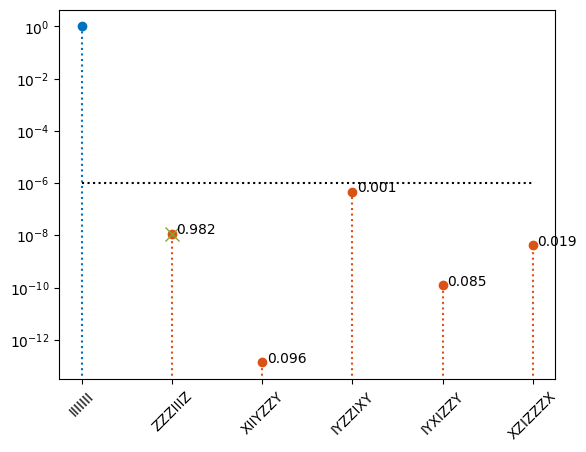

In [13]:
E, B = optimize_krylov(H_tapered, eps_mat=5e-2, N=1, M=5, K=1, seed=97,showfig=True)

Now we can run several steps of the iterative procedure. Cautious, the cell takes ~10min to run.

In [14]:
E, B = optimize_krylov(H_tapered, N=10, M=10, K=1, seed=1001)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


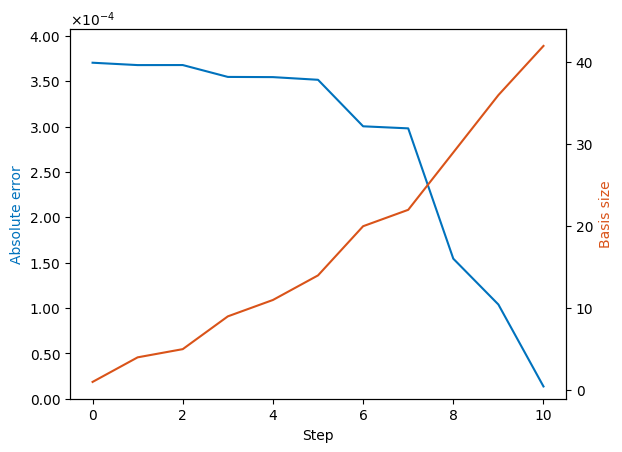

In [15]:
true_GS = eigh(qml.matrix(H_tapered), eigvals_only=True)[0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(E-true_GS, color=[0, 0.4470, 0.7410])
ax2.plot(B, color=[0.8500, 0.3250, 0.0980])
ax1.set_ylim((0,1.1*(E[0]-true_GS)))


from matplotlib.ticker import ScalarFormatter
class ScalarFormatterClass(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.2f"
        
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((-4,-4))
ax1.yaxis.set_major_formatter(yScalarFormatter)

ax1.set_xlabel('Step')
ax1.set_ylabel('Absolute error', color=[0, 0.4470, 0.7410])
ax2.set_ylabel('Basis size', color=[0.8500, 0.3250, 0.0980])


plt.savefig('img/result.png')
plt.show()
#plt.plot(-np.abs(E-true_GS)/true_GS)

#plt.show()

<img src="img/result.png" alt= “” width="600" height="400">

In [16]:
print(E)

[-15.59446755 -15.59447016 -15.59447012 -15.59448321 -15.59448342
 -15.59448637 -15.59453763 -15.59453991 -15.59468355 -15.59473404
 -15.59482438]



This plot shows the absolute error on the ground state energy (IQAE algorithm wrt exact diagonalisation, blue curve), as well as the basis size (orange curve), as function of the iteration step. 
For reference, the exact ground state energy of our model (approximated Hamiltonian) is $-15.594837897448235$ Ha.
After the IQAE procedure, we get $-15.59482438$ Ha.

As we can see, after every iteration the result of the algorithm becomes closer to the true ground state. The VQE result (step 0, only Identity) has a relative error of 2e-5. At the end of 10 iterations, the relative error of the IQAE algorithm is 9e-7.

The gap between the IQAE result and the exact ground state is reduced down to 3% from the gap between the VQE and the exact ground state energy.


As we can see, the precision improvement is very promising considering we only use a subspace of 42 elements out of 16384 (=4^7) possible Pauli Words. We have though to keep in mind that the full Hilbert space has a dimension of $128$ ($=2^7$), so that the method becomes meaningless if we go beyond this limit. However in this case our subspace has a size of 33% of the full Hilbert space, which still provides an advantage over exact diagonalisation. 


Addendum 

One can also try with 3 more iteration:
The IQAE gives $-15.59483485$ Ha

<img src="img/result2.png" alt= “” width="600" height="400">

In [ ]:
# Obtained with this line 
# E, B = optimize_krylov(H_tapered, N=13, M=10, K=1, seed=1001)